# INTRODUCTION

## Goal

The goal of the problem is to predict whether a passenger was satisfied or not considering his/her overall experience of traveling on the Shinkansen Bullet Train.

## Dataset

The problem consists of 2 separate datasets: Travel data & Survey data. Travel data has information related to passengers and attributes related to the Shinkansen train, in which they traveled. The survey data is aggregated data of surveys indicating the post-service experience. You are expected to treat both these datasets as raw data and perform any necessary data cleaning/validation steps as required.

# SET UP

In [332]:
%%capture
!pip install polars

In [333]:
# data processing lib
import numpy as np
import pandas as pd
import polars as pl
from scipy import stats

# data viz lib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly import subplots

# ML lib
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [334]:
train_travel_link = "https://raw.githubusercontent.com/amrirasyidi/mit_idss_hackaton/main/data/Traveldata_train.csv"
train_survey_link = "https://raw.githubusercontent.com/amrirasyidi/mit_idss_hackaton/main/data/Surveydata_train.csv"

test_travel_link = "https://raw.githubusercontent.com/amrirasyidi/mit_idss_hackaton/main/data/Traveldata_test.csv"
test_survey_link = "https://raw.githubusercontent.com/amrirasyidi/mit_idss_hackaton/main/data/Surveydata_test.csv"

## Polars

In [335]:
train_travel_pl = pl.read_csv(train_travel_link, infer_schema_length=0).lazy()
train_survey_pl = pl.read_csv(train_survey_link, infer_schema_length=0).lazy()

test_travel_pl = pl.read_csv(test_travel_link, infer_schema_length=0).lazy()
test_survey_pl = pl.read_csv(test_survey_link, infer_schema_length=0).lazy()

In [336]:
# rename columns

COLUMN_MAPPING = {col:col.lower() for col in train_travel_pl.columns}
train_travel_pl = train_travel_pl.rename(COLUMN_MAPPING)

In [337]:
train_travel_pl = train_travel_pl.with_column(
    pl.col([
        "id",
        "age",
        "travel_distance",
        "departure_delay_in_mins",
        "arrival_delay_in_mins",
        ]).cast(pl.Int64, strict=False)
)

In [338]:
train_travel_pl.head().collect()

id,gender,customer_type,age,type_travel,travel_class,travel_distance,departure_delay_in_mins,arrival_delay_in_mins
i64,str,str,i64,str,str,i64,i64,i64
98800001,"""Female""","""Loyal Customer...",52,null,"""Business""",272,0,5
98800002,"""Male""","""Loyal Customer...",48,"""Personal Trave...","""Eco""",2200,9,0
98800003,"""Female""","""Loyal Customer...",43,"""Business Trave...","""Business""",1061,77,119
98800004,"""Female""","""Loyal Customer...",44,"""Business Trave...","""Business""",780,13,18
98800005,"""Female""","""Loyal Customer...",50,"""Business Trave...","""Business""",1981,0,0


## Pandas

In [339]:
train_travel = pd.read_csv(train_travel_link)
train_survey = pd.read_csv(train_survey_link)

test_travel = pd.read_csv(test_travel_link)
test_survey = pd.read_csv(test_survey_link)

In [340]:
# Overview of the travel data
train_travel.head(3)

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,98800001,Female,Loyal Customer,52.0,NaN,Business,272,0.0,5.0
1,98800002,Male,Loyal Customer,48.0,Personal Travel,Eco,2200,9.0,0.0
2,98800003,Female,Loyal Customer,43.0,Business Travel,Business,1061,77.0,119.0


In [341]:
# Statistics of the travel data
train_travel.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,94379.0,9.884719e+07,27245.014865,98800001.0,98823595.5,98847190.0,98870784.5,98894379.0
Age,94346.0,3.941965e+01,15.116632,7.0,27.0,40.0,51.0,85.0
Travel_Distance,94379.0,1.978888e+03,1027.961019,50.0,1359.0,1923.0,2538.0,6951.0
Departure_Delay_in_Mins,94322.0,1.464709e+01,38.138781,0.0,0.0,0.0,12.0,1592.0
Arrival_Delay_in_Mins,94022.0,1.500522e+01,38.439409,0.0,0.0,0.0,13.0,1584.0


In [342]:
# Info of the travel data
train_travel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.5+ MB


In [343]:
# check duplicates
print("Is there any duplicate in the data? ",train_travel.duplicated().any())

Is there any duplicate in the data?  False


In [344]:
# rename columns

COLUMN_MAPPING = {col:col.lower() for col in train_travel.columns}
train_travel = train_travel.rename(columns = COLUMN_MAPPING)

In [345]:
train_survey.head(3)

,ID,Overall_Experience,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,98800001,0,Needs Improvement,Green Car,Excellent,Excellent,Very Convenient,Good,Needs Improvement,Acceptable,Needs Improvement,Needs Improvement,Acceptable,Needs Improvement,Good,Needs Improvement,Poor
1,98800002,0,Poor,Ordinary,Excellent,Poor,Needs Improvement,Good,Poor,Good,Good,Excellent,Needs Improvement,Poor,Needs Improvement,Good,Good
2,98800003,1,Needs Improvement,Green Car,Needs Improvement,Needs Improvement,Needs Improvement,Needs Improvement,Good,Excellent,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Excellent


In [346]:
train_survey.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,94379.0,9.884719e+07,27245.014865,98800001.0,98823595.5,98847190.0,98870784.5,98894379.0
Overall_Experience,94379.0,5.466576e-01,0.497821,0.0,0.0,1.0,1.0,1.0


In [347]:
train_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       94379 non-null  int64 
 1   Overall_Experience       94379 non-null  int64 
 2   Seat_Comfort             94318 non-null  object
 3   Seat_Class               94379 non-null  object
 4   Arrival_Time_Convenient  85449 non-null  object
 5   Catering                 85638 non-null  object
 6   Platform_Location        94349 non-null  object
 7   Onboard_Wifi_Service     94349 non-null  object
 8   Onboard_Entertainment    94361 non-null  object
 9   Online_Support           94288 non-null  object
 10  Ease_of_Online_Booking   94306 non-null  object
 11  Onboard_Service          86778 non-null  object
 12  Legroom                  94289 non-null  object
 13  Baggage_Handling         94237 non-null  object
 14  CheckIn_Service          94302 non-nul

In [348]:
# rename columns

COLUMN_MAPPING_SURVEY = {col:col.lower() for col in train_survey.columns}
train_survey = train_survey.rename(columns = COLUMN_MAPPING_SURVEY)

In [349]:
# to unify the rating, we will convert values in platform_location column

odd_val = [
    "Very Inconvenient",
    "Inconvenient",
    "Needs Improvement",
    "Manageable",
    "Convenient",
    "Very Convenient"
    ]
correct_val = [
    "Extremely Poor",
    "Poor",
    "Needs Improvement",
    "Acceptable",
    "Good",
    "Excellent"
]

VALUE_MAPPING_SURVEY = dict(zip(odd_val,correct_val))

In [350]:
train_survey['platform_location'] = train_survey['platform_location'].map(VALUE_MAPPING_SURVEY)

### Some changes made

- train_travel
  - rename column
- train_survey
  - rename column
  - unify rating name

## Classes and Functions

In [351]:
# transforming categorical column into numerical labels
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

# visualize null count as horizontal bar plot
def null_viz(data = train_travel):
  NULL_COUNT = pd.DataFrame(data.isna().sum()).reset_index().rename(columns = {'index':'variable',0:'count'}).sort_values(by='count')
  NULL_COUNT['pct'] = (NULL_COUNT['count']/data.shape[0])

  fig, ax = plt.subplots(figsize = (15,6))

  width = .8

  bars = NULL_COUNT['count'].plot.barh(color='green', ax=ax, width=width)

  for i, v in enumerate(NULL_COUNT['pct']):
      ax.text(v + 100, i, '{:.2%}'.format(v), fontweight='bold')

  ax.set_ylabel('Variable');
  ax.set_yticklabels(NULL_COUNT.variable.to_list());

  ax.set_xlabel('Count');

  ax.set_title("Null Value \nCount and Percentage", fontsize=20, fontweight='bold', fontfamily='monospace')

  return (fig, ax)

# visualize categorical variable distribution as horizontal bar plot
def cat_distribution(data = train_travel, nrows = 2, ncols = 2, width = 15, height = 6, val_order = 'count'):
  fig, ax = plt.subplots(nrows,ncols, figsize = (width,height))
  plt.suptitle("Distribution of\nCategorical Variables", fontsize=20, fontweight='bold', fontfamily='monospace', y = 1.1)

  col = data.select_dtypes(exclude=np.number).columns.tolist()

  for var,axs in zip(col, ax.flatten()):
    if val_order == 'count':
      orders = data[var].fillna("Null").value_counts().index
    else:
      orders = ["Null"]+correct_val

    cnt = sns.countplot(
        y = data[var].fillna("Null"),
        ax = axs,
        color = 'lightblue',
        order = orders
    )

    cnt.set_ylabel('')
    cnt.set_title(var, fontweight = 'bold')

  plt.tight_layout()

  return (fig, ax)

# visualize numerical variable distribution as histogram
def num_distribution(data = train_travel, nrows = 2, ncols = 2, width = 15, height = 6):
  fig, ax = plt.subplots(nrows,ncols, figsize = (width,height))
  plt.suptitle("Distribution of\nNumerical Variables", fontsize=20, fontweight='bold', fontfamily='monospace', y = 1.1)

  col = data.select_dtypes(include=np.number).columns.tolist()[1:]

  for var,axs in zip(col, ax.flatten()):
    cnt = sns.histplot(
        x = data[var],
        ax = axs,
        color = 'lightblue'
    )

    cnt.set_ylabel('')
    cnt.set_title(var, fontweight = 'bold')

  plt.tight_layout()

  return (fig, ax)

# visualize variable correlation heatmap
def corr_heatmap(data = train_travel, width = 16, height = 12):
  # https://www.kdnuggets.com/2021/04/awesome-tricks-best-practices-kaggle.html

  # Calculate pairwise-correlation
  matrix = data.corr()

  # Create a mask
  mask = np.triu(np.ones_like(matrix, dtype=bool))

  # Create a custom diverging palette
  cmap = sns.diverging_palette(250, 15, s=75, l=40,n=9, 
                              center="light", 
                              as_cmap=True
                              )

  plt.figure(figsize=(width, height))
  plt.title("Variable Correlation Heatmap", fontsize=20, fontweight='bold', fontfamily='monospace')
  sns.heatmap(matrix, mask=mask, center=0, annot=True, 
              fmt='.2f', square=True, cmap=cmap)
  
  return (fig, ax)

# EXPLORATION

## Travel

In [352]:
NULL_COUNT = pd.DataFrame(train_travel.isna().sum()).reset_index().rename(columns = {'index':'variable',0:'count'}).sort_values(by='count')
NULL_COUNT['pct'] = (NULL_COUNT['count']/train_travel.shape[0])

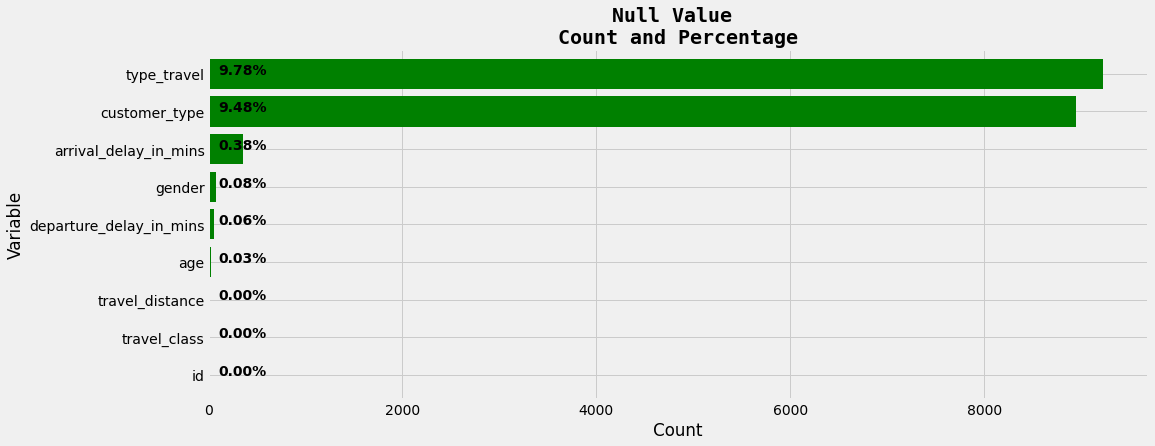

In [353]:
null_viz();

### Univariate

In [354]:
CAT_COL = train_travel.select_dtypes(exclude=np.number).columns.tolist()
NUM_COL = train_travel.select_dtypes(include=np.number).columns.tolist()[1:]

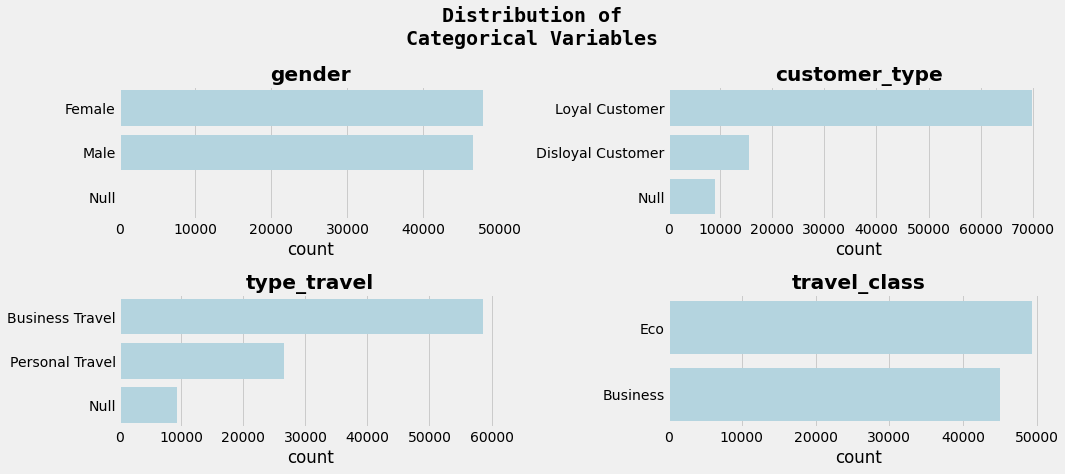

In [355]:
cat_distribution();

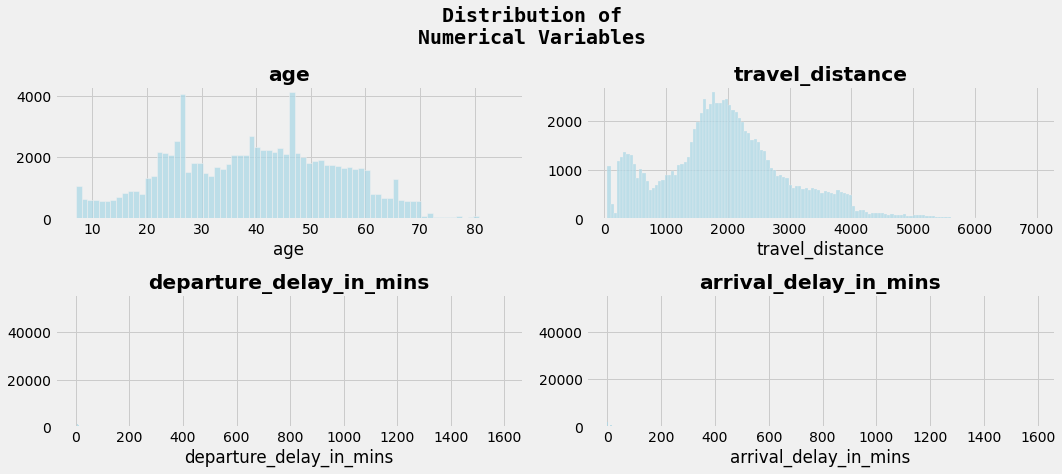

In [356]:
num_distribution();

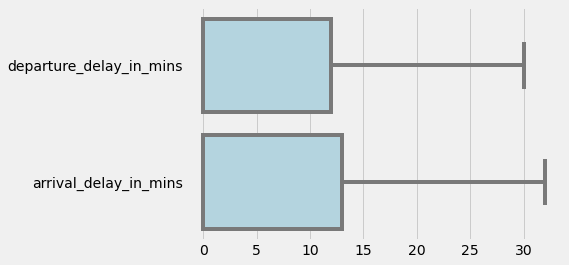

In [357]:
sns.boxplot(
    data = train_travel[['departure_delay_in_mins', 'arrival_delay_in_mins']],
    orient = 'h',
    color = 'lightblue',
    showfliers = False
)

#### Observation

- Categorical
  - Gender and travel class are relatively evenly distributed
  - Customer type and travel type are imbalanced
- Numerical
  - There are spikes in age around 26 and 46 years old passengers. Without the spike, the distribution is almost bell shaped
  - Travel distance has a bimodal distribution, around 500 and 2000 distances
  - Delay, both in departure and arrival seems to have an outliers. The distribution is very spread out as suggested by the statistics (`.describe()`)

### Multivariate

In [358]:
plot_table = train_travel.fillna("Null")

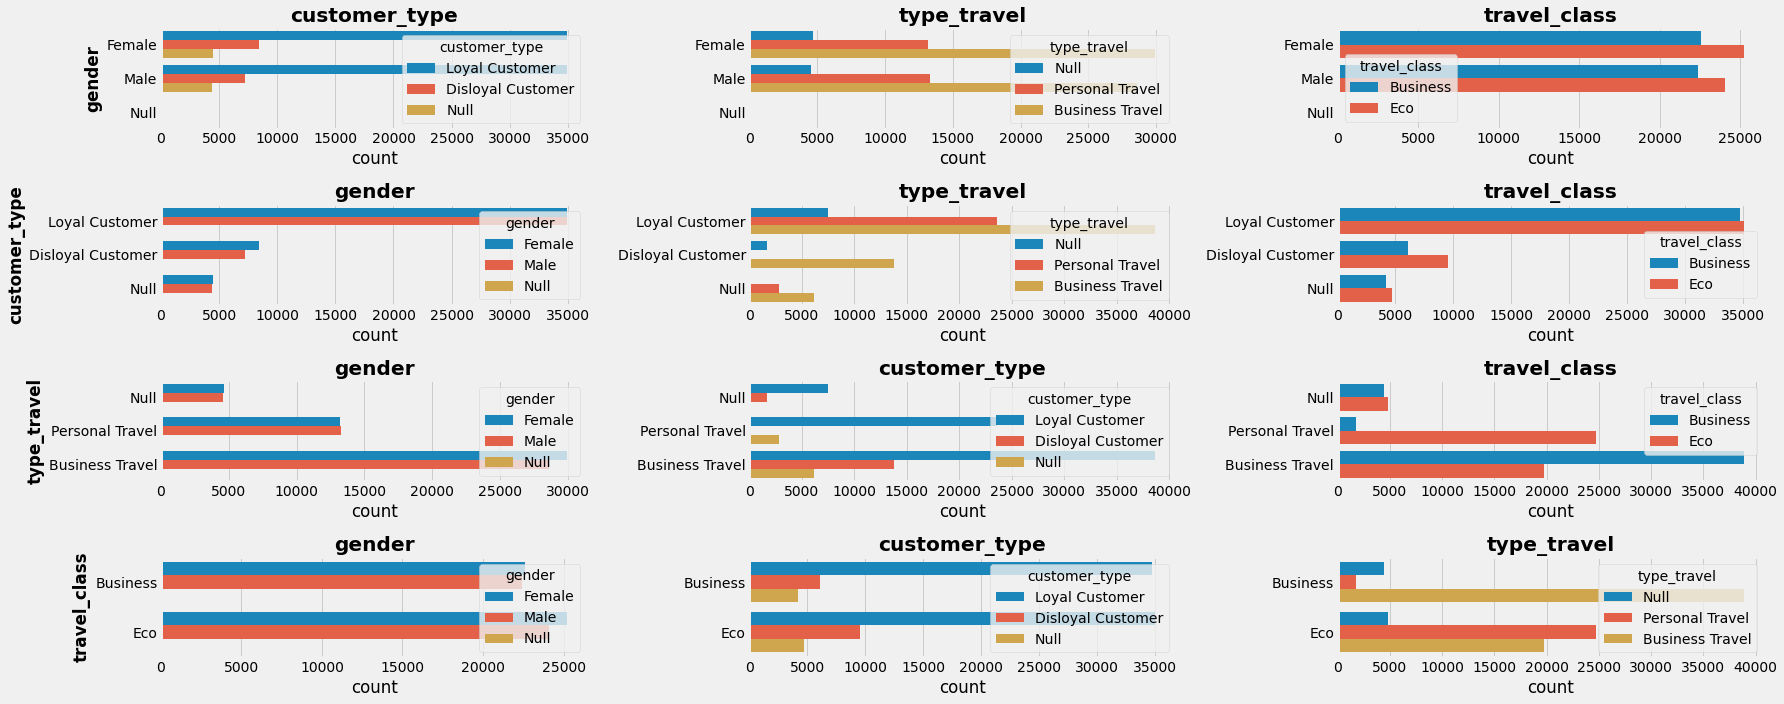

In [359]:
fig, ax = plt.subplots(4,3,figsize = (25,10));

ax_start = 0

for var in CAT_COL:  
  TEMP_LIST = CAT_COL.copy()
  TEMP_LIST.pop(TEMP_LIST.index(var))

  ax_end = ax_start+3

  for col, axs in zip(TEMP_LIST, ax.flatten()[ax_start:ax_end]):
    cnt = sns.countplot(
        data = plot_table, 
        y = var, 
        hue = col,
        ax = axs
        )
    
    if ax_start%3 == 0:
      cnt.set_ylabel(var, fontweight = 'bold')
    else:
      cnt.set_ylabel('')
    
    cnt.set_title(col, fontweight = 'bold')
    ax_start+=1

plt.tight_layout()

In [360]:
TEMP = train_travel[CAT_COL]

TEMP_TABLE = MultiColumnLabelEncoder(columns = CAT_COL).fit_transform(TEMP)

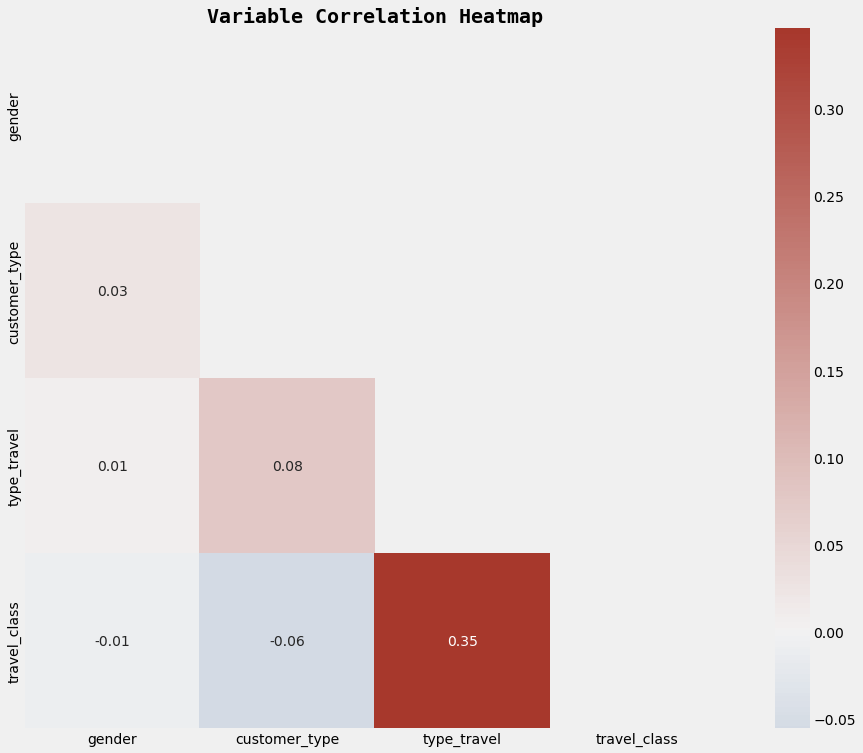

In [361]:
corr_heatmap(TEMP_TABLE);

In [362]:
# sns.pairplot(data = train_travel[NUM_COL], corner=True)

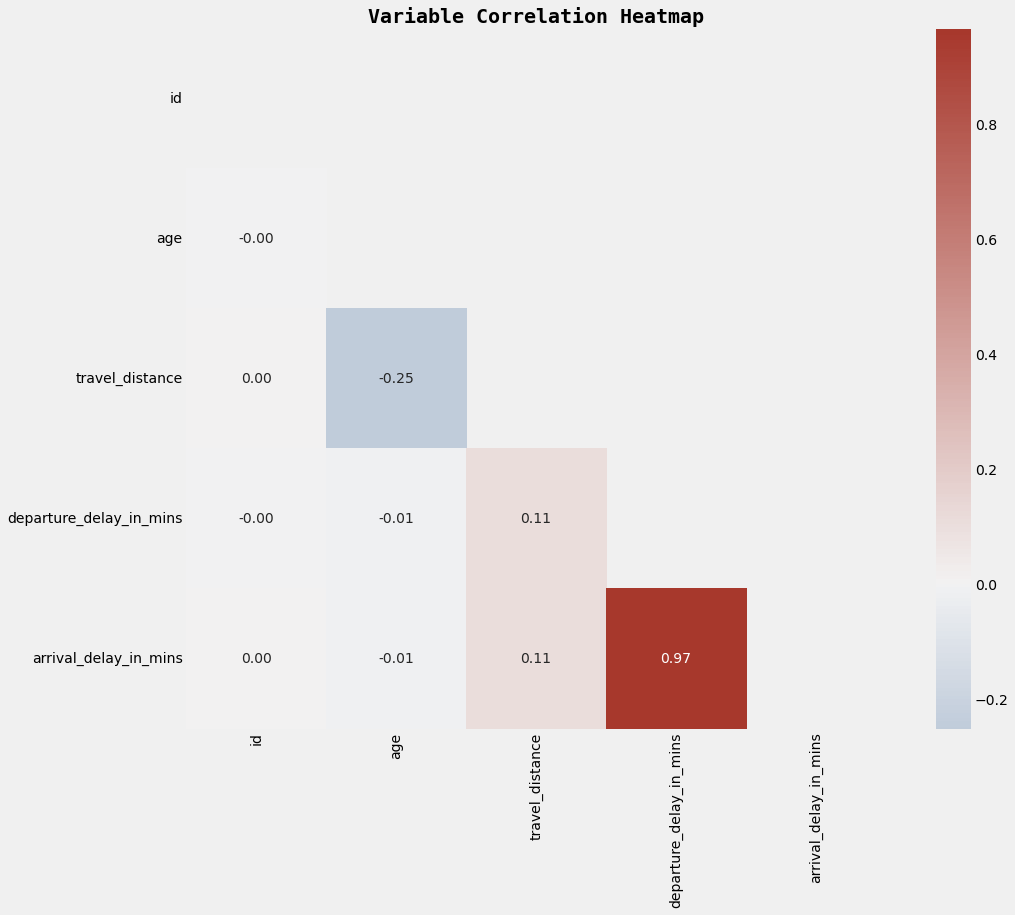

In [363]:
corr_heatmap(train_travel);

#### Observation

- Categorical
  - From the heatmap and the barplot, there are no strong correlation between categorical variables

- Numerical
  - From the heatmap and the pairplot, we see that departure and arrival delay have a strong correlation, almost completely linear with `0.97` correlation score.

## Survey

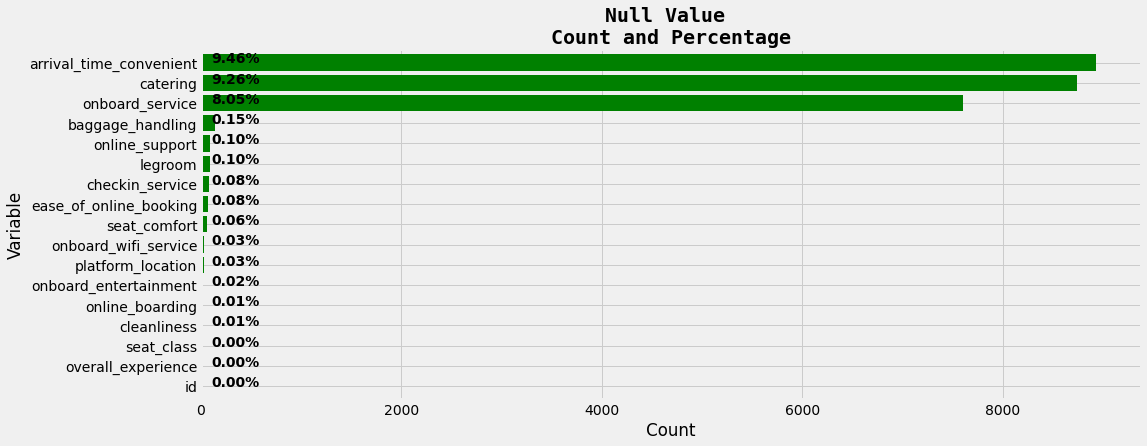

In [364]:
# check null value distribution
null_viz(train_survey);

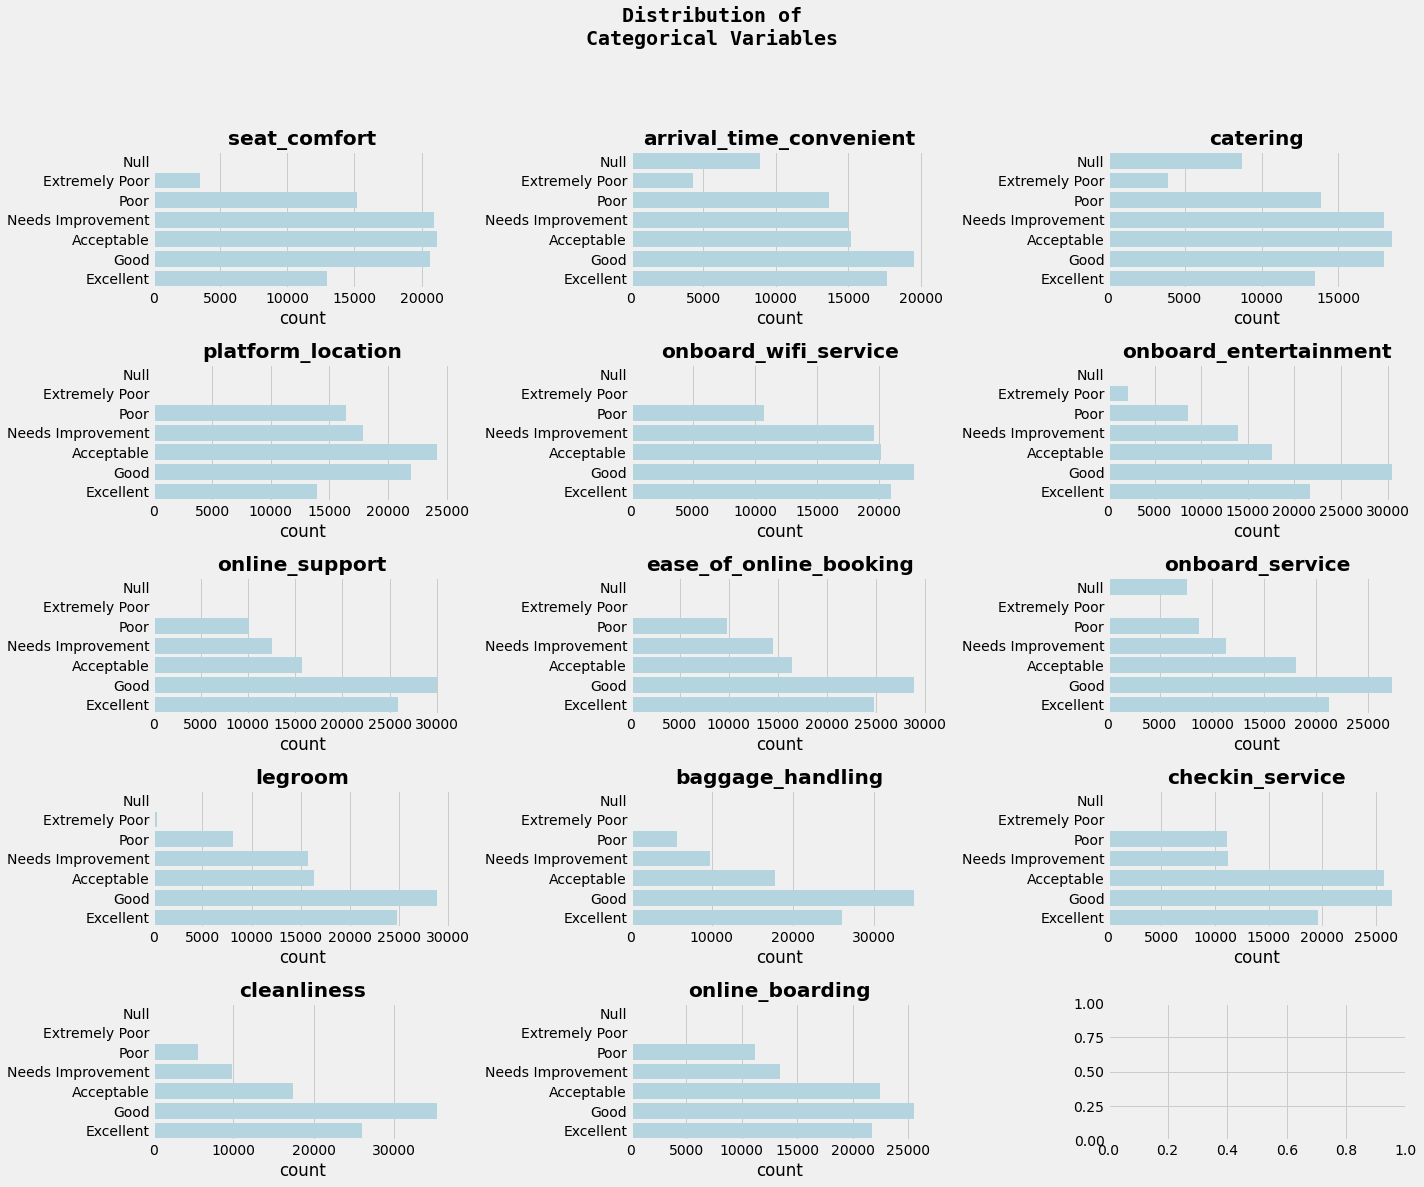

In [365]:
cat_distribution(data = train_survey.drop('seat_class', axis = 1), ncols=3, nrows=5, width = 20, height = 15, val_order = 'x');

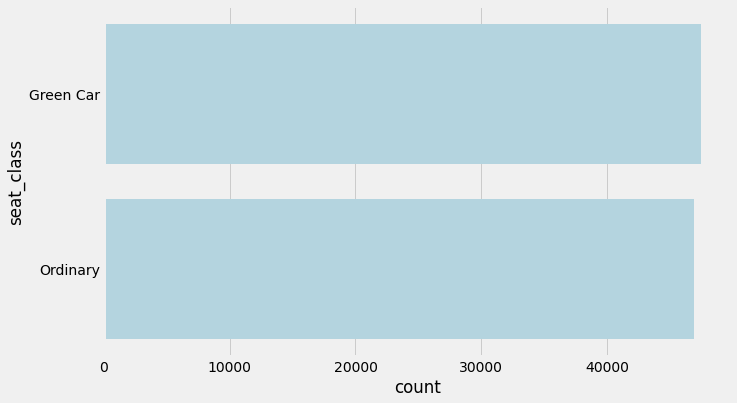

In [366]:
fig, ax = plt.subplots(figsize = (10,6))

sns.countplot(
    data = train_survey,
    y = 'seat_class',
    ax = ax,
    color = 'lightblue'
)

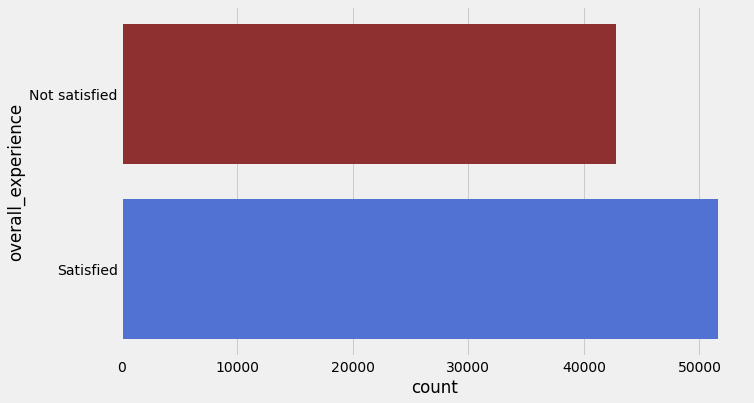

In [367]:
fig, ax = plt.subplots(figsize = (10,6))

sns.countplot(
    data = train_survey,
    y = 'overall_experience',
    ax = ax,
    palette=['#9e2020','#3c67e8'],
)

ax.set_yticklabels(['Not satisfied', 'Satisfied']);

In [368]:
TEMP_SURVEY = train_survey.copy()
# TEMP_SURVEY = MultiColumnLabelEncoder(columns = TEMP_SURVEY.columns[2:]).fit_transform(TEMP_SURVEY)

label_val = [0,1,2,3,4,5]
# label_val = list(map(int, label_val))

LABEL_MAP = dict(zip(correct_val, label_val))

for i in TEMP_SURVEY.drop(columns = 'seat_class').columns[2:]:
  TEMP_SURVEY[i] = TEMP_SURVEY[i].map(LABEL_MAP)
  TEMP_SURVEY[i] = TEMP_SURVEY[i].astype('Int64')

In [369]:
TEMP_SURVEY.head()

,id,overall_experience,seat_comfort,seat_class,arrival_time_convenient,catering,platform_location,onboard_wifi_service,onboard_entertainment,online_support,ease_of_online_booking,onboard_service,legroom,baggage_handling,checkin_service,cleanliness,online_boarding
0,98800001,0,2,Green Car,5,5,5,4,2,3,2,2,3,2,4,2,1
1,98800002,0,1,Ordinary,5,1,2,4,1,4,4,5,2,1,2,4,4
2,98800003,1,2,Green Car,2,2,2,2,4,5,5,5,5,5,4,5,5
3,98800004,0,3,Ordinary,2,<NA>,2,3,2,3,3,3,3,3,4,3,3
4,98800005,1,3,Ordinary,3,3,3,2,4,5,4,4,4,4,4,4,4


In [370]:
# sns.pairplot(data = TEMP_SURVEY.drop(columns = ['id']), hue = 'overall_experience', corner=True)

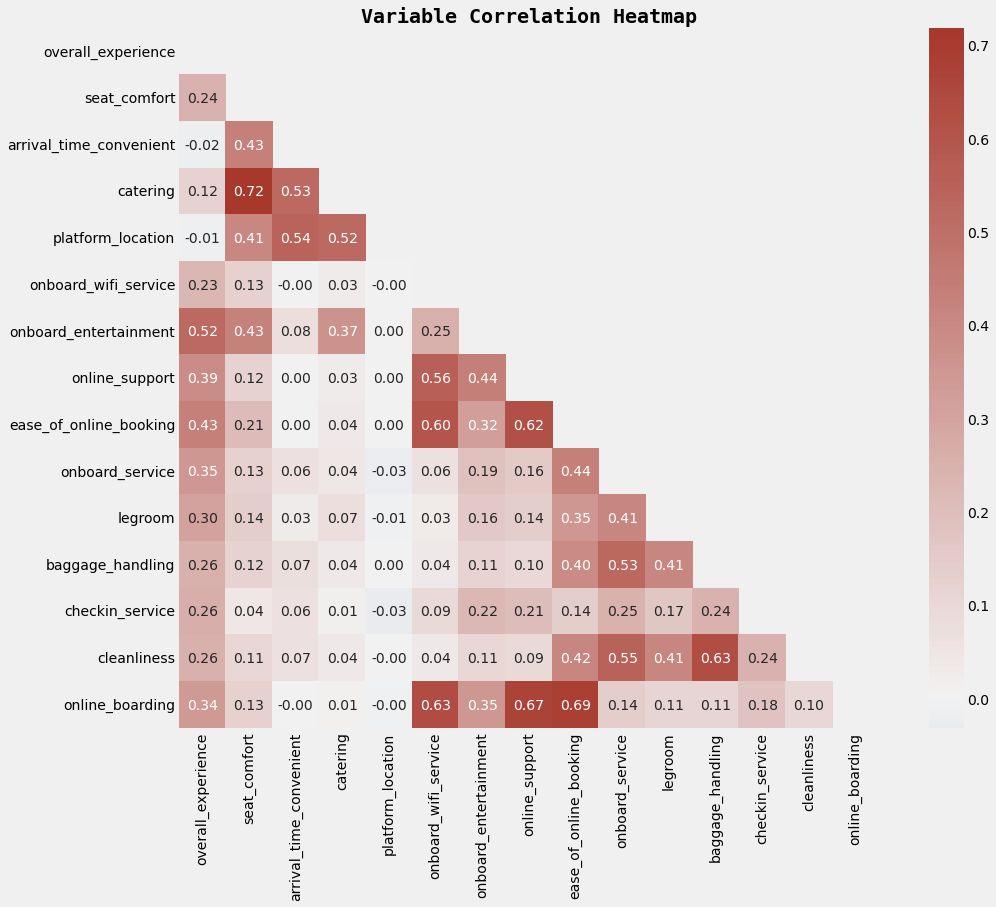

In [371]:
corr_heatmap(TEMP_SURVEY.drop(columns = ['id']));

# DATA ENGINEERING

- (Optional) Check the union of id from both table, then merge table
- Travel columns
  - Null values
    - `age`, `gender` - mode
    - `arrival_delay` - try using linear regression from `departure_delay`
    - `departure_delay` - drop
    - `customer_type` - fill with "disloyal"
    - `type_travel` - if class == eco then personal, else business
  - Outliers
    - `delay` use z score
  - Scaler/normalize/standardize `age`, `distance`, `delay`
  - OHE `gender`, `type_travel`
  - Label encode `customer_type`, `travel_class`
  - Drop `id` -- unimportant
  - Drop one of the `delay` -- strong correlation
- Survey columns
  - Null values - mode or just drop
  - OHE `seat_class`
  - Label encode everything else
- Continue with PCA (check variability)

In [372]:
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelEncoder

In [373]:
# check id matchness between travel and survey
pd.Series(train_travel.id == train_survey.id).unique()

array([ True])

## Travel

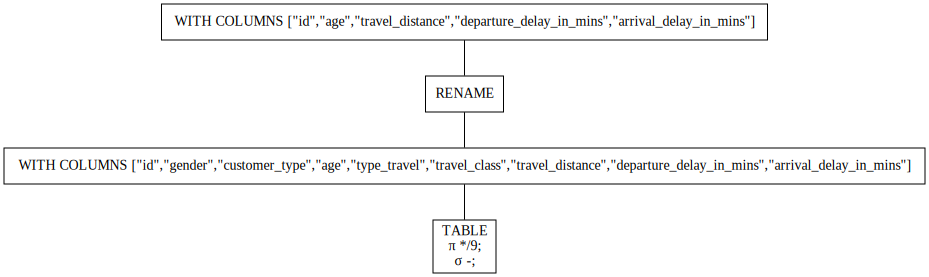

In [374]:
# checking changes made so far
train_travel_pl.show_graph()

In [375]:
train_travel_pl.head(3).collect()

id,gender,customer_type,age,type_travel,travel_class,travel_distance,departure_delay_in_mins,arrival_delay_in_mins
i64,str,str,i64,str,str,i64,i64,i64
98800001,"""Female""","""Loyal Customer...",52,null,"""Business""",272,0,5
98800002,"""Male""","""Loyal Customer...",48,"""Personal Trave...","""Eco""",2200,9,0
98800003,"""Female""","""Loyal Customer...",43,"""Business Trave...","""Business""",1061,77,119


In [376]:
# copy the lazyframe

train_travel_pl_clone = train_travel_pl.clone()

### Fill null values

In [377]:
# fill null values

train_travel_pl_clone = train_travel_pl_clone.with_columns([
    pl.col("age").fill_null(pl.col("age").mode()),
    pl.col("gender").fill_null(pl.col("gender").mode()),
    pl.col("customer_type").fill_null(pl.lit("Disloyal Customer")),
    pl.col("type_travel").fill_null(pl.when(pl.col("travel_class") == "Eco").then(pl.lit("Personal Travel")).otherwise(pl.lit("Business Travel"))),
])

### Drop null and outliers

In [378]:
# calculating zscore for depart delay in mins

depart_series = train_travel_pl_clone.select(
    pl.col("arrival_delay_in_mins")
    ).collect().to_pandas()["arrival_delay_in_mins"]

depart_zscore = np.abs(stats.zscore(
    depart_series,nan_policy='omit'
    )
)

train_travel_pl_clone = train_travel_pl_clone.with_column(
    pl.Series(name="depart_zscore", values=depart_zscore)
)

In [379]:
# drop null values and outliers

train_travel_pl_clone = train_travel_pl_clone.filter(
    (~pl.col("arrival_delay_in_mins").is_null())
    & (pl.col("depart_zscore") < 3)
)

In [380]:
# double check null values
train_travel_pl_clone.collect().null_count()

id,gender,customer_type,age,type_travel,travel_class,travel_distance,departure_delay_in_mins,arrival_delay_in_mins,depart_zscore
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0


In [381]:
train_travel_pl_clone.collect().shape

(92053, 10)

### Standardize the values

Using min max scaler

In [382]:
# prepare a dataframe to be plot as a comparison before applying the scaler
before_scale = train_travel_pl_clone.select([
    pl.col('age'),
    pl.col('travel_distance'),
    pl.col('departure_delay_in_mins'),
    pl.col('arrival_delay_in_mins'),
]).collect()

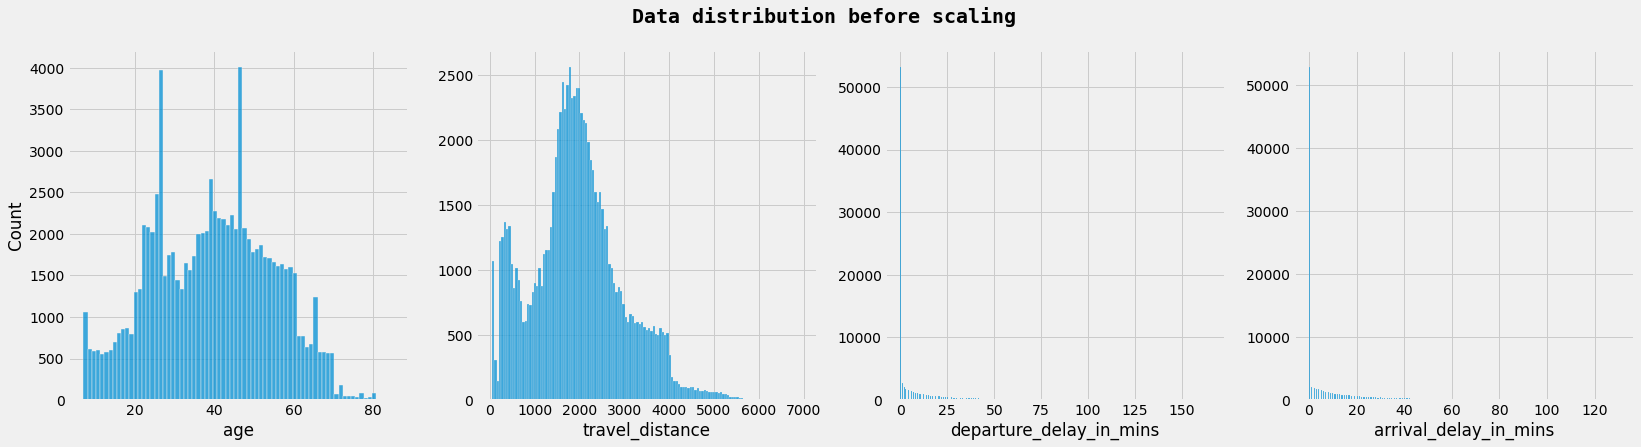

In [383]:
fig, ax = plt.subplots(1,4, figsize = (25,6))

for i,j in zip(before_scale.columns, ax.flatten()):
  hist = sns.histplot(
      data = before_scale,
      x = i,
      ax = j
  )

  if i != 'age':
    hist.set_ylabel('');

plt.suptitle("Data distribution before scaling", fontsize = 20, fontweight = 'bold', fontfamily = 'monospace');
plt.tight_layout;

In [384]:
scaler = MinMaxScaler()

In [385]:
after_scale_pd = before_scale.to_pandas()

In [386]:
scaled_col = [i+'_scaled' for i in before_scale.columns]

after_scale_pd[scaled_col] = scaler.fit_transform(after_scale_pd)

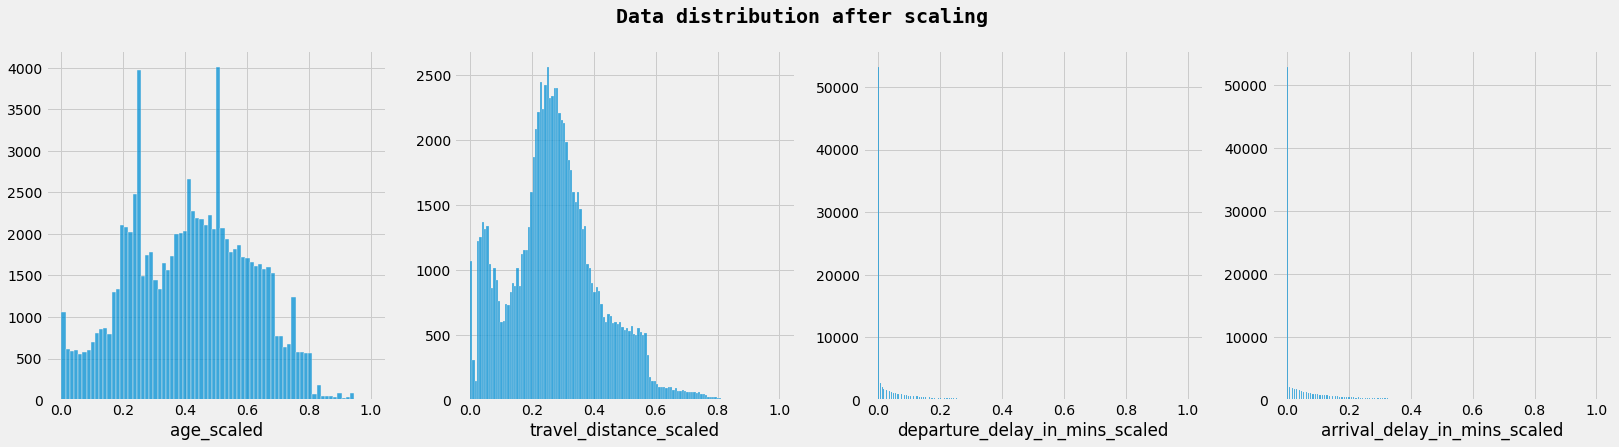

In [387]:
fig, ax = plt.subplots(1,4, figsize = (25,6))

for i,j in zip(after_scale_pd.columns[4:], ax.flatten()):
  hist = sns.histplot(
      data = after_scale_pd,
      x = i,
      ax = j
  )

  if i != 'age':
    hist.set_ylabel('');

plt.suptitle("Data distribution after scaling", fontsize = 20, fontweight = 'bold', fontfamily = 'monospace');
plt.tight_layout;

In [388]:
after_scale_pd = after_scale_pd[scaled_col]
after_scale_pd

,age_scaled,travel_distance_scaled,departure_delay_in_mins_scaled,arrival_delay_in_mins_scaled
0,0.576923,0.032169,0.000000,0.038462
1,0.525641,0.311549,0.054545,0.000000
2,0.461538,0.146501,0.466667,0.915385
3,0.474359,0.105782,0.078788,0.138462
4,0.551282,0.279815,0.000000,0.000000
...,...,...,...,...
92048,0.320513,0.189393,0.503030,0.961538
92049,0.474359,0.078539,0.030303,0.084615
92050,0.717949,0.397624,0.000000,0.000000
92051,0.115385,0.390378,0.000000,0.000000


### Encoding categorical values

In [389]:
train_travel_pl_clone.head(3).collect()

id,gender,customer_type,age,type_travel,travel_class,travel_distance,departure_delay_in_mins,arrival_delay_in_mins,depart_zscore
i64,str,str,i64,str,str,i64,i64,i64,f64
98800001,"""Female""","""Loyal Customer...",52,"""Business Trave...","""Business""",272,0,5,0.260287
98800002,"""Male""","""Loyal Customer...",48,"""Personal Trave...","""Eco""",2200,9,0,0.390362
98800003,"""Female""","""Loyal Customer...",43,"""Business Trave...","""Business""",1061,77,119,2.705435


In [390]:
before_encode = train_travel_pl_clone.select([
    pl.col("gender"),
    pl.col("type_travel"),
    pl.col("customer_type"),
    pl.col("travel_class")
]).collect()

In [391]:
# get the one hot encoded values

OHE = pd.get_dummies(before_encode.to_pandas().iloc[:,:2])

In [392]:
OHE.head(3)

,gender_Female,gender_Male,type_travel_Business Travel,type_travel_Personal Travel
0,1,0,1,0
1,0,1,0,1
2,1,0,1,0


In [393]:
num_val = [0,1]

cust_type_val = ["Disloyal Customer", "Loyal Customer"]
travel_type_val = ["Personal Travel", "Business Travel"]

CUST_TYPE_MAP = dict(zip(cust_type_val, num_val))
TRAVEL_TYPE_MAP = dict(zip(travel_type_val, num_val))

In [394]:
label_encode = before_encode.to_pandas()

In [395]:
# Label encode the ordinal value

label_encode['customer_type_enc'] = label_encode['customer_type'].map(CUST_TYPE_MAP)
label_encode['type_travel_enc'] = label_encode['type_travel'].map(TRAVEL_TYPE_MAP)

In [396]:
label_encode = label_encode.iloc[:,-2:]
after_encode = pd.merge(label_encode, OHE, left_index=True, right_index=True)
after_encode

,customer_type_enc,type_travel_enc,gender_Female,gender_Male,type_travel_Business Travel,type_travel_Personal Travel
0,1,1,1,0,1,0
1,1,0,0,1,0,1
2,1,1,1,0,1,0
3,1,1,1,0,1,0
4,1,1,1,0,1,0
...,...,...,...,...,...,...
92048,1,1,0,1,1,0
92049,1,1,0,1,1,0
92050,0,1,0,1,1,0
92051,1,0,0,1,0,1


### Merging the data

In [397]:
train_travel_pl_clone.collect().to_pandas()['id']

0        98800001
1        98800002
2        98800003
3        98800004
4        98800005
           ...   
92048    98894375
92049    98894376
92050    98894377
92051    98894378
92052    98894379
Name: id, Length: 92053, dtype: int64

In [398]:
df_final = pd.merge(after_scale_pd, after_encode, left_index=True, right_index=True)
df_final = pd.merge(train_travel_pl_clone.collect().to_pandas()[['id']], df_final, left_index=True, right_index=True)
df_final.head(3)

,id,age_scaled,travel_distance_scaled,departure_delay_in_mins_scaled,arrival_delay_in_mins_scaled,customer_type_enc,type_travel_enc,gender_Female,gender_Male,type_travel_Business Travel,type_travel_Personal Travel
0,98800001,0.576923,0.032169,0.000000,0.038462,1,1,1,0,1,0
1,98800002,0.525641,0.311549,0.054545,0.000000,1,0,0,1,0,1
2,98800003,0.461538,0.146501,0.466667,0.915385,1,1,1,0,1,0


In [399]:
train_travel.head(3)

,id,gender,customer_type,age,type_travel,travel_class,travel_distance,departure_delay_in_mins,arrival_delay_in_mins
0,98800001,Female,Loyal Customer,52.0,NaN,Business,272,0.0,5.0
1,98800002,Male,Loyal Customer,48.0,Personal Travel,Eco,2200,9.0,0.0
2,98800003,Female,Loyal Customer,43.0,Business Travel,Business,1061,77.0,119.0


## Survey

In [400]:
# train_survey.head()

In [401]:
# label encoded train survey
# TEMP_SURVEY.head()

# MACHINE LEARNING

In [402]:
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV

from sklearn.linear_model import LogisticRegression

# Metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, recall_score, roc_curve, auc, accuracy_score

In [403]:
# Creating metric function 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Satisfied', 'Satisfied'], yticklabels=['Not Satisfied', 'Satisfied'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## Train only using travel data

### Logistic regression

In [404]:
# get the target value accordingly

df_travel = pd.merge(df_final, train_survey[['id','overall_experience']], on = 'id')
df_travel = df_travel.drop(columns = 'arrival_delay_in_mins_scaled') # drop one of the delay column to prevent multicollinearity
df_travel.head(3)

,id,age_scaled,travel_distance_scaled,departure_delay_in_mins_scaled,customer_type_enc,type_travel_enc,gender_Female,gender_Male,type_travel_Business Travel,type_travel_Personal Travel,overall_experience
0,98800001,0.576923,0.032169,0.000000,1,1,1,0,1,0,0
1,98800002,0.525641,0.311549,0.054545,1,0,0,1,0,1,0
2,98800003,0.461538,0.146501,0.466667,1,1,1,0,1,0,1


In [405]:
X = df_travel.iloc[:,1:-2]
Y = df_travel['overall_experience']

In [406]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1)

In [407]:
# Fitting logistic regression model

lg=LogisticRegression()
lg.fit(X_train, y_train)

LogisticRegression()

              precision    recall  f1-score   support

           0       0.73      0.61      0.67     28814
           1       0.72      0.82      0.77     35623

    accuracy                           0.73     64437
   macro avg       0.73      0.71      0.72     64437
weighted avg       0.73      0.73      0.72     64437



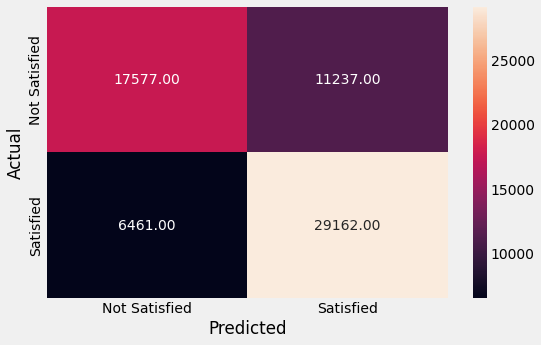

In [408]:
# Checking the performance on the training data
y_pred_train = lg.predict(X_train)

metrics_score(y_train, y_pred_train)

              precision    recall  f1-score   support

           0       0.74      0.61      0.67     12534
           1       0.72      0.82      0.77     15082

    accuracy                           0.73     27616
   macro avg       0.73      0.72      0.72     27616
weighted avg       0.73      0.73      0.72     27616



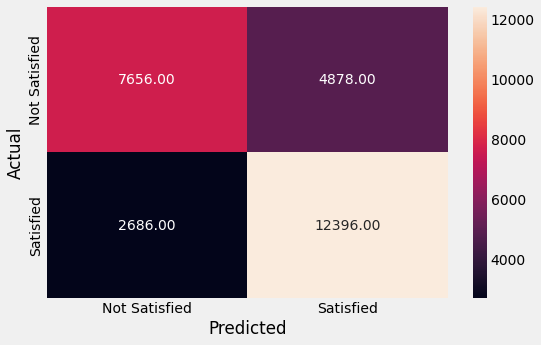

In [409]:
# Checking the performance on the test dataset
y_pred_test = lg.predict(X_test)

metrics_score(y_test, y_pred_test)

In [410]:
# Printing the coefficients of logistic regression
cols=X.columns

coef_lg=lg.coef_

pd.DataFrame(coef_lg,columns=cols).T.sort_values(by = 0,ascending = False)

,0
customer_type_enc,1.415000
gender_Female,0.506824
type_travel_enc,0.450908
type_travel_Business Travel,0.450908
age_scaled,0.443675
travel_distance_scaled,-0.271547
gender_Male,-0.507301
departure_delay_in_mins_scaled,-1.038412


In [411]:
# Finding the odds
odds = np.exp(lg.coef_[0]) 

# Adding the odds to a dataframe and sorting the values
pd.DataFrame(odds, X_train.columns, columns = ['odds']).sort_values(by ='odds', ascending = False) 

,odds
customer_type_enc,4.116488
gender_Female,1.660010
type_travel_enc,1.569737
type_travel_Business Travel,1.569737
age_scaled,1.558424
travel_distance_scaled,0.762200
gender_Male,0.602119
departure_delay_in_mins_scaled,0.354016


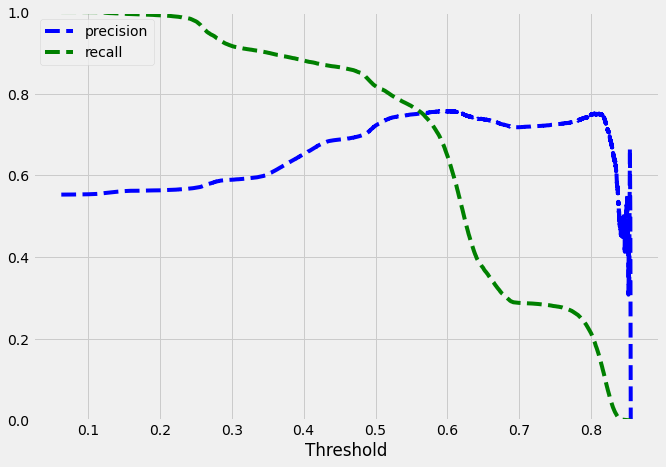

In [412]:
# Predict_proba gives the probability of each observation belonging to each class
y_scores_lg=lg.predict_proba(X_train)

precisions_lg, recalls_lg, thresholds_lg = precision_recall_curve(y_train, y_scores_lg[:,1])

# Plot values of precisions, recalls, and thresholds
plt.figure(figsize=(10,7))
plt.plot(thresholds_lg, precisions_lg[:-1], 'b--', label='precision')
plt.plot(thresholds_lg, recalls_lg[:-1], 'g--', label = 'recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.show()

              precision    recall  f1-score   support

           0       0.71      0.68      0.69     28814
           1       0.75      0.77      0.76     35623

    accuracy                           0.73     64437
   macro avg       0.73      0.73      0.73     64437
weighted avg       0.73      0.73      0.73     64437



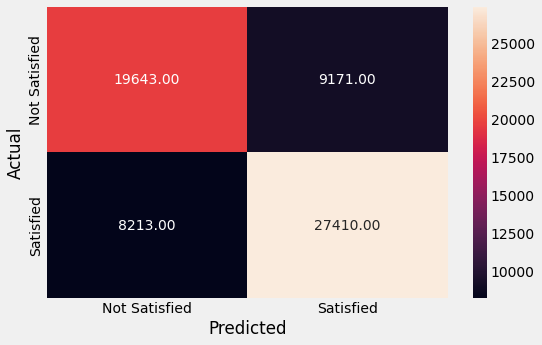

In [413]:
optimal_threshold=.55
y_pred_train = lg.predict_proba(X_train)

metrics_score(y_train, y_pred_train[:,1]>optimal_threshold)

### XGBoost

In [414]:
import xgboost as xgb
from xgboost import plot_importance

In [415]:
# XGB baseline

model = xgb.XGBClassifier(verbosity = 0)
model.fit(X_train, y_train)

XGBClassifier(verbosity=0)

In [416]:
model.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'nthread': 1,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'subsample': 1,
 'verbosity': 0}

In [417]:
expected_y  = y_test
predicted_y = model.predict(X_test)

In [418]:
tn, fp, fn, tp = metrics.confusion_matrix(expected_y, predicted_y).ravel()
conf_matrix = metrics.confusion_matrix(expected_y, predicted_y)

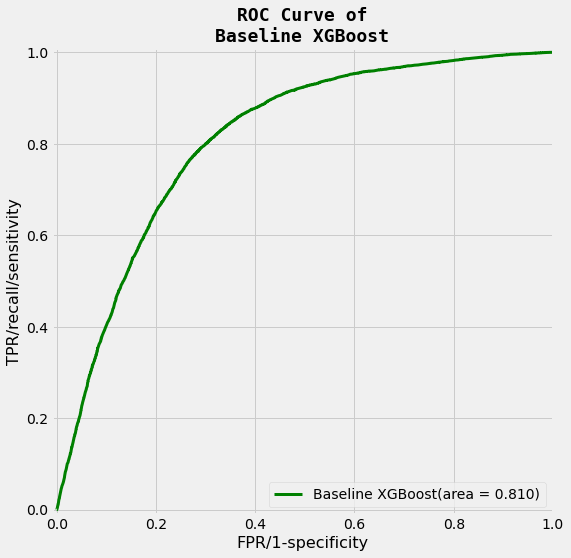

In [419]:
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc_grd_xgb = auc(fpr_xgb, tpr_xgb)

# fpr_dummy, tpr_dummy, thresholds_dummy = roc_curve(y_test, dummy_clf.predict_proba(X_test)[:, 1])
# roc_auc_grd_dummy = auc(fpr_dummy, tpr_dummy)

fig, ax = plt.subplots(figsize = (8,8))

# plt.plot(fpr_dummy, tpr_dummy, label="Dummy Classifier(area = {:0.3f})".format(roc_auc_grd_dummy), lw = 2, linestyle='--', color = 'red')
plt.plot(fpr_xgb, tpr_xgb, label="Baseline XGBoost(area = {:0.3f})".format(roc_auc_grd_xgb), lw = 3, color = 'green')

plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.xlabel("FPR/1-specificity", fontsize=16)
plt.ylabel("TPR/recall/sensitivity", fontsize=16)
plt.title('ROC Curve of\nBaseline XGBoost', fontsize=18, fontfamily = 'monospace', fontweight = 'bold')
plt.legend(loc=4)

In [420]:
xgb_score = cross_val_score(model, X_test, y_test, scoring = 'accuracy', cv=10)
print(f'Mean model score: {xgb_score.mean():.3f} ± {xgb_score.std():.3f}')

Mean model score: 0.756 ± 0.006


In [421]:
# initialize data of lists.
data = {
    'Metrics': ['True Negative','False Positive','False Negative','True Positive', 'CV Accuracy Avg', 'CV Accuracy Std'],
    'Baseline':[tn, fp, fn, tp, xgb_score.mean(), xgb_score.std()]
}
  
# Create DataFrame
metrics_eval = pd.DataFrame(data)

metrics_eval

,Metrics,Baseline
0,True Negative,8290.000000
1,False Positive,4244.000000
2,False Negative,2474.000000
3,True Positive,12608.000000
4,CV Accuracy Avg,0.756083
5,CV Accuracy Std,0.005856


              precision    recall  f1-score   support

           0       0.77      0.66      0.71     12534
           1       0.75      0.84      0.79     15082

    accuracy                           0.76     27616
   macro avg       0.76      0.75      0.75     27616
weighted avg       0.76      0.76      0.75     27616



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


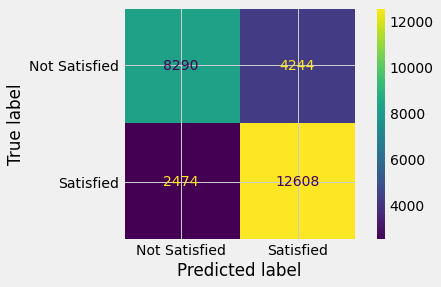

In [422]:
print(metrics.classification_report(expected_y, predicted_y))

metrics.plot_confusion_matrix(
    model,
    X_test,
    y_test,
    values_format = 'd',
    display_labels = ['Not Satisfied','Satisfied']
)